In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps
import pickle

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline

np.seterr(all='raise')
tfd = tfp.distributions


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from datasets import *

In [3]:
data_set_small = load_data_set('./datasets/100.10')
data_set_big = load_data_set('./datasets/100.100')

In [4]:
%%writefile basic_solutions.py

import numpy as np
from scipy.optimize import minimize
import scipy.stats as sps
from matplotlib import pyplot as plt

def cut01(ans):
    ans[ans <= 1e-4] = 1e-4
    ans[ans >= 1 - 1e-4] = 1 - 1e-4
    return ans

def bayesian_solve(alpha0, beta0, train, L):
    ans = (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
    return cut01(ans)

def calc_loglike(p_pred, val, L):
    return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()

def calc_bayesian_solve_loglike(alpha0, beta0, train, val, L, use_prior=False):
    p_pred = bayesian_solve(alpha0, beta0, train, L)
    ans = calc_loglike(p_pred, val, L)
    if use_prior:
        m = alpha0 / (alpha0 + beta0)
        s = alpha0 + beta0
        ans += sps.beta.logpdf(m, 1, 10)
        ans += sps.norm(4, 1).logpdf(np.log(s))
    return ans

def stupid_solution(train, val, L):
    return (train + val + 1e-4) / 2 / (L + 2e-4)

def calc_llp(p_pred, train, test, L):
    p_const = train.sum() / L / train.shape[0]
    if p_const < 1e-4:
        p_const = 1e-4
    return (calc_loglike(p_pred, test, 1e6) - calc_loglike(p_const, test, 1e6)) / 1e6 / test.shape[0]

def evaluate(solution_fun, train, val, test, L):
    p_pred = solution_fun(train, val, L)
    if np.any(p_pred == 0):
        raise Exception("Zero predicted probability")
        

    print ("p_pred", p_pred[:5])
    print (test[:5] / 1e6)
    plt.hist(test / 1e6, bins=20, density=True)
    plt.show()
    return calc_llp(p_pred, train + val, test, 2 * L)

def max_loglike_solution(train, val, L):
    loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], train, val, L)
    try:
        res = minimize(fun=lambda x: -loglike(1 + np.exp(x)), x0=(1, 1))
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if not res.success:
        return mean_value_solution(train, val, L)
    else:
        return bayesian_solve(1 + np.exp(res.x[0]), 1 + np.exp(res.x[1]), train + val, L * 2)
    
def mean_value_solution(train, val, L):
    m = ((train + val) / 2. / L).mean()
    if m < 1e-4:
        m = 1e-4
    sum_ab = 1 / m * 20
    return bayesian_solve(m * sum_ab, (1 - m) * sum_ab, train + val, 2 * L)

def calibration_curve_solution(train, val, L):
    try:
        line = sps.linregress((val) / L, (train) / L, )
    except FloatingPointError as e:
        return max_loglike_solution(train, val, L)
    if line.slope == 0:
        return max_loglike_solution(train, val, L)
    tg = 1 / line.slope
    sum_ab = tg * L - L + 2
    #m = ((train + val) / 2 / L).mean()
    m = (L * line.intercept / line.slope + 1) / sum_ab
    if tg != tg or m * sum_ab < 1 or sum_ab > 1e5 or m > 1:
        return max_loglike_solution(train, val, L)
    
    print (m * sum_ab, sum_ab * (1 - m))

    plt.hist((train + val) / L / 2, bins=20, density=True)
    space = np.linspace(0, .2, 100)
    plt.plot(space, sps.beta(m * sum_ab, sum_ab * (1 - m)).pdf(space))
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)

def mean_std_prior(p):
    m = p.mean()
    sq_std = p.std() ** 2
    if sq_std == 0:
        return None, None
    sum_ab = m * (1 - m) / sq_std
    if m * sum_ab < 1 or sum_ab != sum_ab:
        return None, None
    return m * sum_ab, (1 - m) * sum_ab

def mean_std_value_solution(train, val, L, iters=10):
    alpha, beta = mean_std_prior((train + val) / 2 / L)
    
    for i in range(iters):
        if alpha is None:
            return mean_value_solution(train, val, L)
        p = bayesian_solve(alpha, beta, train + val, 2 * L)
        alpha, beta = mean_std_prior(p)

    if alpha is None:
        return mean_value_solution(train, val, L)
    
    return bayesian_solve(alpha, beta, train + val, 2 * L)

Overwriting basic_solutions.py


p_pred [0.1000015  0.07500175 0.1000015  0.07500175 0.02500225]
[0.078361 0.019043 0.114232 0.048724 0.056708]


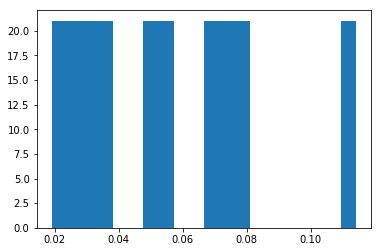

-0.09069752620606533

In [5]:
from basic_solutions import *

evaluate(stupid_solution, data_set_small.train_data[0], data_set_small.val_data[0], data_set_small.ideal[0], data_set_small.L)

In [6]:
from tqdm import tqdm_notebook as tqdm

def super_puper_solution(train, val, L):
    m_ = np.linspace(0, 1, 100)
    sum_ab_ = np.linspace(3, 1000, 100)
    log_prob = []
    for m in tqdm(m_):
        for sum_ab in sum_ab_:
            alpha = m * sum_ab
            beta = (1 - m) * sum_ab
            log_prob.append(calc_bayesian_solve_loglike(alpha, beta, train, val, L, True))
    log_prob = np.array(log_prob) - np.max(log_prob)
    log_prob[log_prob < -30] = -30.
    prior_prob = np.exp(log_prob)
    i = 0
    p_pred = np.zeros_like(train, dtype=np.float32)
    for m in tqdm(m_):
        for sum_ab in sum_ab_:
            alpha = m * sum_ab
            beta = (1 - m) * sum_ab
            p_pred += bayesian_solve(alpha, beta, train + val, L * 2) * prior_prob[i]
            i += 1
    p_pred /= prior_prob.sum()
    return p_pred


def super_puper_solution2(train, val, L):
    size = 3000
    m_ = np.random.uniform(0, 1, size=size)
    sum_ab_ = np.random.uniform(3, 1000, size=size)
    log_prob = []
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        log_prob.append(calc_bayesian_solve_loglike(alpha, beta, train, val, L))

    log_prob = np.array(log_prob) - np.max(log_prob)
    log_prob[log_prob < -30] = -30.
    prior_prob = np.exp(log_prob)
    p_pred = np.zeros_like(train, dtype=np.float32)
    
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        p_pred += bayesian_solve(alpha, beta, train + val, L * 2) * prior_prob[i]
    p_pred /= prior_prob.sum()
    return p_pred

In [7]:
def modified_calibration_curve_solution(train, val, L):
    try:
        points = np.array([val[train == i].mean() for i in train])
        line = sps.linregress((points) / L, (train) / L, )
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if line.slope == 0:
        return mean_value_solution(train, val, L)
    tg = line.slope
    sum_ab = tg * L - L + 2
    m = ((train + val) / 2 / L).mean()
    if tg != tg or m * sum_ab < 1 or sum_ab > 1e5:
        return mean_value_solution(train, val, L)
    
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)

In [8]:
def evaluate_compare(solutions, ds, plot=False, labels=[], best=True):
    llps = [[] for _ in solutions]
    #print (ds.train_data.shape)
    for t_id in (range(ds.train_data.shape[0])):
        for i, solution in enumerate(solutions):
            score = evaluate(solution, ds.train_data[t_id], ds.val_data[t_id], ds.ideal[t_id], ds.L)
            if score != score or score == float('inf') or score == float('-inf'):
                print (t_id, i)
                raise Exception("unnormal score")
            llps[i].append(score)
    if best:
        llps.append([])
        labels.append("true")
        for t_id in range(ds.train_data.shape[0]):
            train = ds.train_data[t_id] + ds.val_data[t_id]
            print (ds.alpha0[t_id], ds.beta0[t_id])
            plt.hist(train / ds.L / 2, bins=20, density=True)
            plt.hist(ds.ideal[t_id] / 1e6, bins=20, density=True)
            space = np.linspace(0, .2, 100)
            plt.plot(space, sps.beta(ds.alpha0[t_id], ds.beta0[t_id]).pdf(space))
            plt.show()
            p_pred = bayesian_solve(ds.alpha0[t_id], ds.beta0[t_id], train, 2 * ds.L)
            print ("true p_pred", p_pred[:5])
            print (ds.ideal[t_id][:5] / 1e6)
            llps[-1].append(calc_llp(p_pred, train, ds.ideal[t_id], 2 * ds.L))


    min_ = 1e9
    max_ = -1e9
    ans = []
    
    good = np.ones(len(llps[0]), dtype=np.bool)
    for solution_scores in llps:
        sc = np.array(solution_scores)
        good &= sc == sc
        good &= sc != np.inf
        good &= sc != float("-inf")
    
    for solution_scores in llps:
        sc = np.array(solution_scores)
        print (sc)
        ans.append((sc[good].mean(), good.sum()))
        min_ = min(min_, sc[good].min())
        max_ = max(max_, sc[good].max())

        
    if plot:
        for i, label in enumerate(labels):
            plt.hist(llps[i], bins=20, alpha=0.5, label=label + ", %.5f" % ans[i][0], range=(min_, max_))
        plt.ylabel('количество тестов', fontsize=18)
        plt.xlabel('llp', fontsize=18)
        plt.legend(title='# method, mean_score')
        plt.grid()
        plt.show()
        
    return ans

23.24682529897669 371.15361854271976
p_pred [0.06432531 0.0530556  0.04554246 0.06432531 0.06808188]
[0.055503 0.066485 0.020411 0.083324 0.078266]


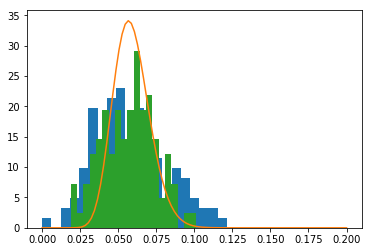

2.536237589866487 48.417031838411575
p_pred [0.02929951 0.06105339 0.12985347 0.02400719 0.00813025]
[0.049234 0.080476 0.142206 0.015561 0.011808]


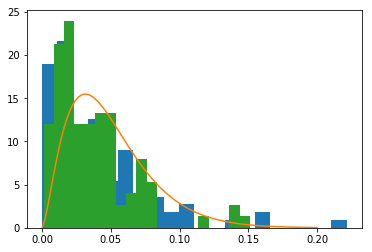

8.67272575475295 132.51472105955412


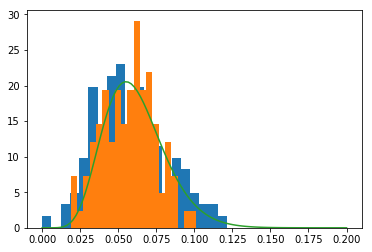

true p_pred [0.07046422 0.04897328 0.03464599 0.07046422 0.07762787]
[0.055503 0.066485 0.020411 0.083324 0.078266]
1.6270114514916223 45.30231566611047


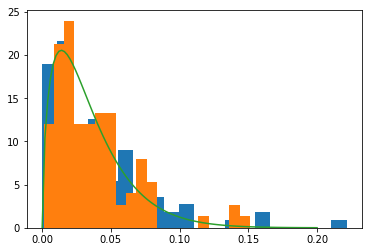

true p_pred [0.02502043 0.05746526 0.12776238 0.01961296 0.00339055]
[0.049234 0.080476 0.142206 0.015561 0.011808]
[0.00084253 0.00760597]
[0.0009716  0.00665692]



In [9]:
L = 70
n = 100

ers = []
for i in tqdm(range(1)):
    ans = evaluate_compare([
            calibration_curve_solution,
        ], DataSet(2, n, L, random_seed=i), False, [
            'calibration_curve'
        ], True)
    #for i in range(len(ans)):
    #    print (ans[i])
    ers.append([ans[0][0], ans[1][0]])
ers = np.array(ers)

In [10]:
ers = np.array(ers)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(ers[:,0], alpha=0.5, label='calibration_curve', bins=20)
plt.hist(ers[:,1], alpha=0.5, label='true', bins=20)
plt.ylabel('количество тестов', fontsize=14)
plt.xlabel("llp", fontsize=14)
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(ers[:,1] - ers[:,0], label='diff', bins=20)
plt.xlabel("delta llp", fontsize=14)
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 

In [ ]:
L = 70
n = 100

ers = []
for i in tqdm(range(2000)):
    ds = DataSet(2, n, L, random_seed=i)
    ans = evaluate_compare([
            true_prior_solution,
            calibration_curve_solution,
        ], ds, False, [
            'max_loglike_on_val', 'calibration_curve'
        ], False)
    ers.append([ans[0][0], ans[1][0], ds.alpha0[0], ds.beta0[0]])

In [ ]:
from matplotlib.cm import rainbow

ers = np.array(ers)
dif = ers[:, 1] - ers[:, 0]
dif -= dif.min()
dif /= dif.max()
ids = dif > 0.15
cols = rainbow(dif[ids])
plt.scatter(np.log(ers[ids, 2]), np.log(ers[ids,3]), c=cols)
plt.show()
(ers[:, 1] - ers[:, 0]).min(), (ers[:, 1] - ers[:, 0]).max()

In [ ]:
for L in [10, 30, 50, 70, 100, 300]:
    for n in [10, 20, 40, 100]:
#for L, n in [(70, 100), (100, 200), (3000, 40)]:
        print (L, n)
        plt.figure()
        plt.title("L = %d, nClasses = %d" % (L, n,), fontsize=18)
        ans = evaluate_compare([
                max_loglike_solution,
                mean_std_value_solution,
                calibration_curve_solution,
            ], DataSet(300, n, L, random_seed=42), True, [
                'max_loglike_on_val', 'mean_std', 'calibration_curve'
            ], True)
        for i in range(len(ans)):
            print (ans[i])

In [ ]:
evaluate_compare([
    stupid_solution,
    mean_value_solution,
    max_loglike_solution,
    max_loglike_solution2,
    calibration_curve_solution,
    mean_std_value_solution,
    modified_calibration_curve_solution,
    super_puper_solution2,
], data_set_big, True, [
    'stup', 'm', 'll', 'll2', 'cc', 'ms', 'cc2', 'sp'
])

In [ ]:
for L in [10, 20, 30, 50, 70, 100, 150, 200, 300, 1000, 3000]:
    print (L)
    ans = evaluate_compare([
            stupid_solution,
            mean_value_solution,
            max_loglike_solution,
            max_loglike_solution2,
            calibration_curve_solution,
            mean_std_value_solution,
            modified_calibration_curve_solution,
            super_puper_solution2,
        ], DataSet(200, 20, L, random_seed=42), True, [
            'stup', 'm', 'll', 'll2', 'cc', 'ms', 'cc2', 'sp'
        ])
    for i in range(len(ans)):
        print (ans[i])